# 라이브러리 임포트

In [1]:
import string
import numpy as np
import pandas as pd
from numpy import array
from PIL import Image
import pickle

import matplotlib.pyplot as plt
import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re


import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

# 데이터 불러오기 및 전처리


pepper 고추 데이터셋

In [191]:
image_path_pepper = "C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/project_dataset/project_dataset/train/pepper_images/"
dir_labelling = pd.read_csv(r"C:\Users\DI Lee\Desktop\Korean_Based_Image_Captioning_Model-main\project_dataset\project_dataset\train\label\crop_label.csv", encoding='cp949').drop('Unnamed: 0', axis=1)

In [193]:
dir_labelling.head()

,Unnamed: 0.1,images,captions
0,0,V006_79_0_00_04_03_12_0_b10_20201012_0000_S01_...,애호박 잎에 특별한 병이 검출되지 않은 것으로 보아 정상으로 판단됩니다
1,1,V006_79_0_00_04_03_12_0_b10_20201012_0000_S01_...,애호박 잎에서 특별한 질병이 발견되지 않았기 때문에 정상으로 간주됩니다
2,2,V006_79_0_00_04_03_12_0_b10_20201012_0000_S01_...,특별한 질병이 애호박 잎에서 발견되지 않았기 때문에 정상으로 간주됩니다
3,3,V006_79_0_00_04_03_12_0_b10_20201012_0000_S01_...,특별한 질병이 애호박 잎에서 검출되지 않은 것으로 보아 정상으로 판단됩니다
4,4,V006_79_0_00_04_03_12_0_b10_20201012_0000_S01_...,애호박 잎에서 특별한 질병이 발견되지 않았기 때문에 정상으로 판단됩니다


In [194]:
ls = os.listdir(image_path)
len([f for f in ls if '.npy' not in f]) #train 이미지 총 개수

24795

# 4개의 이미지에 대해, 각 이미지에 5개씩 대응되는 라벨 문장 출력해보기

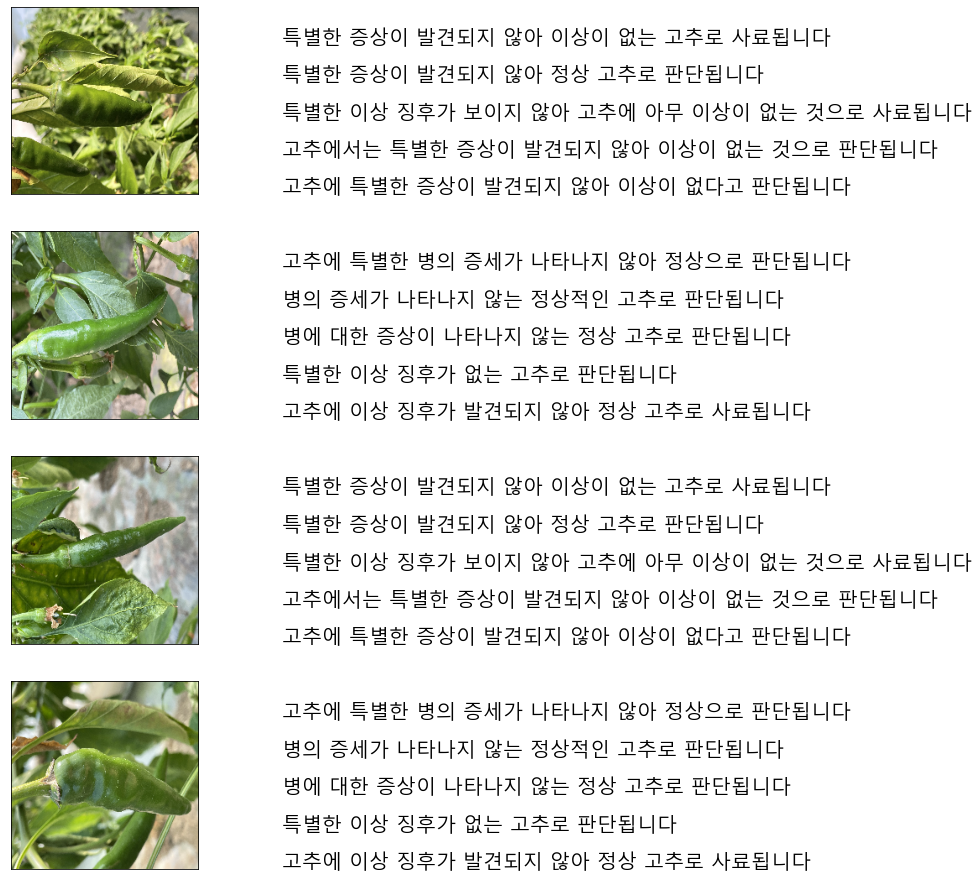

In [195]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in np.unique(dir_labelling['images'])[10:14]:
    filename = image_path + '/' + jpgfnm
    captions = list(dir_labelling["captions"].loc[dir_labelling["images"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

# Vocabulary size 확인

In [196]:
vocabulary = []
for text in dir_labelling.captions.values:
    vocabulary.extend(text.split()) #토크나이징을 공백(띄어쓰기) 기준으로 수행(나중에 형태소단위로 토크나이징 시도해볼 수 있음)

vocabulary = list(set(vocabulary))
print(f'vocabulary 사이즈는 {len(vocabulary)} 입니다.')

vocabulary 사이즈는 147 입니다.


In [197]:
vocabulary[:15]

['흰가루병으로',
 '노란색의',
 '곳으로',
 '밀가루를',
 '보이지',
 '질병이',
 '바른',
 '원형반점과',
 '수',
 '뇨균병으로',
 '황색인',
 '연한',
 '고추로',
 '둘러',
 '많이']

# 문장에 \<start>, \<end> 토큰 부착하기

In [198]:
attached_captions = []
for caption in dir_labelling['captions']:
    caption = '<start> ' + caption + ' <end>'
    attached_captions.append(caption)

In [199]:
attached_captions[:10]

['<start> 애호박 잎에 특별한 병이 검출되지 않은 것으로 보아 정상으로 판단됩니다 <end>',
 '<start> 애호박 잎에서 특별한 질병이 발견되지 않았기 때문에 정상으로 간주됩니다 <end>',
 '<start> 특별한 질병이 애호박 잎에서 발견되지 않았기 때문에 정상으로 간주됩니다 <end>',
 '<start> 특별한 질병이 애호박 잎에서 검출되지 않은 것으로 보아 정상으로 판단됩니다 <end>',
 '<start> 애호박 잎에서 특별한 질병이 발견되지 않았기 때문에 정상으로 판단됩니다  <end>',
 '<start> 잎에서 검출되는 질병이 없기 때문에 정상적인 애호박으로 판단됩니다. <end>',
 '<start> 잎에서 질병이 검출되지 않아 정상적인 애호박으로 판단됩니다 <end>',
 '<start> 특별한 질병이 애호박 잎에서 검출되지 않았기 때문에 정상으로 간주됩니다 <end>',
 '<start> 특별한 증상이 애호박 잎에서 나타나지 않은 것으로 보아 정상으로 판단됩니다 <end>',
 '<start> 잎에서 검출되는 특별한 증상이 없기 때문에 정상 애호박으로 판단됩니다 <end>']

# 이미지 전체 경로 리스트(중복포함임)

In [200]:
all_img_name_vector = []
for file in dir_labelling['images']:
    full_img_path = image_path + file
    all_img_name_vector.append(full_img_path)

all_img_name_vector[:7]

['C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/project_dataset/project_dataset/train/pepper_images/V006_79_0_00_04_03_12_0_b10_20201012_0000_S01_1.jpg',
 'C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/project_dataset/project_dataset/train/pepper_images/V006_79_0_00_04_03_12_0_b10_20201012_0000_S01_1.jpg',
 'C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/project_dataset/project_dataset/train/pepper_images/V006_79_0_00_04_03_12_0_b10_20201012_0000_S01_1.jpg',
 'C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/project_dataset/project_dataset/train/pepper_images/V006_79_0_00_04_03_12_0_b10_20201012_0000_S01_1.jpg',
 'C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/project_dataset/project_dataset/train/pepper_images/V006_79_0_00_04_03_12_0_b10_20201012_0000_S01_1.jpg',
 'C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/project_dataset/project_dataset/train/pepper_images/V006_79_0_00_04_

In [201]:
print(f'전체 이미지 경로 개수(all_img_name_vector) : {len(all_img_name_vector)}\n전체 캡션 개수(attached_captions) : {len(attached_captions)}')

전체 이미지 경로 개수(all_img_name_vector) : 224865
전체 캡션 개수(attached_captions) : 224865


# 이미지 특징 추출하는 모델(이미지 캡셔닝 모델의 인코더 부분) 정의하기

In [202]:
#이미지 읽어오는 함수
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet') #InceptionV3 이미지 특징 추출
new_input = image_model.input
hidden_layer = image_model.layers[-1].output #이미지 분류를 하지 않으므로 마지막 layer인 softmax 층을 제거함. 즉, 이미지에서 특징만 추출

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)#이미지 특징 추출 모델


In [203]:
#개수가 같은 전체 캡션 개수 배열(array)과 전체 이미지 이름 배열에 대해 일관된 순서로 데이터를 섞는다.
#두 배열에서 같은 행 인덱스에 있던 값은 데이터가 섞인 뒤에도 서로 같은 위치에 있다.
train_captions, img_name_vector = shuffle(attached_captions, all_img_name_vector, random_state=1)

### 이미지를 읽어오기 위해 이미지를 읽어오는 함수(load_image)에 각 이미지 이름을 대응(map)시킨다.

In [157]:
encoded_train = sorted(set(img_name_vector)) #집합으로 변환하는 이유: 코드 처리 속도 빠르게 하기 위해서, 중복없는 이미지만 있게 하려고(혹시 모르니까)
image_dataset = tf.data.Dataset.from_tensor_slices(encoded_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

### 이미지에서 특징을 추출하고, 각 특징을 넘파이 형식의 파일(.npy)로 변환하여 저장한다. 이후 이 넘파이 형식의 파일은 인코더에 입력된다.
- 넘파이 형식의 파일은 자료형과 행렬크기정보  등 어느 컴퓨터에나 배열(array)을 재구성하는데 필요한 모든 정보를 저장한다.

In [79]:
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
  
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████████████████████████████████████████████████████████████████████████| 1511/1511 [05:02<00:00,  5.00it/s]


# 캡션 전처리 및 토큰화
- 캡션을 토크나이징하여 중복 없는 단어들로 구성된 사전을 구축한다
- 구두점은 모두 제거함
- 혹시 사전에 없는 단어가 있으면 해당 단어는 \<unk> 토큰으로 대체함
- 그 후 각 단어에 인덱스를 부여하고, 단어:인덱스 형식으로 변형한다.
- 모델 학습을 위해 모든 문장의 길이를 맞춰줘야 하는데 이를 위해 모든 문장(시퀀스)를 가장 길이가 긴 문장의 길이에 맞춘다. 길이는 0으로 padding하여 맞춘다.

In [204]:
#토크나이저 생성
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token = '<unk>',
                                                  filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [205]:
train_seqs = tokenizer.texts_to_sequences(train_captions)
print(train_seqs[:10])

[[2, 65, 55, 56, 16, 33, 8, 27, 17, 7, 5, 13, 6, 3], [2, 58, 30, 31, 33, 32, 16, 35, 36, 41, 17, 7, 5, 13, 6, 3], [2, 37, 66, 19, 9, 23, 28, 59, 22, 49, 4, 103, 57, 3], [2, 37, 66, 19, 9, 23, 28, 59, 22, 49, 4, 103, 57, 3], [2, 11, 46, 50, 25, 9, 17, 7, 5, 12, 6, 3], [2, 46, 50, 25, 9, 29, 40, 45, 93, 7, 5, 94, 6, 3], [2, 24, 47, 52, 54, 75, 76, 85, 21, 3], [2, 11, 8, 95, 35, 36, 41, 14, 15, 13, 6, 3], [2, 25, 61, 40, 51, 29, 26, 34, 22, 5, 12, 6, 3], [2, 19, 9, 37, 42, 79, 23, 28, 80, 22, 49, 4, 20, 10, 3]]


In [206]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [207]:
print(tokenizer.word_index)

{'<unk>': 1, '<start>': 2, '<end>': 3, '애호박': 4, '보아': 5, '의심됩니다': 6, '것으로': 7, '담황색': 8, '반점이': 9, '판단됩니다': 10, '고추에': 11, '고추탄저병으로': 12, '고추흰가루병으로': 13, '잎에': 14, '발견되어': 15, '같은': 16, '나타나는': 17, '흰가루병으로': 18, '부정형': 19, '노균병으로': 20, '사료됩니다': 21, '것을': 22, '잎의': 23, '특별한': 24, '원형': 25, '말라': 26, '병무늬가': 27, '앞면에': 28, '나타나고': 29, '서릿발': 30, '모양의': 31, '이슬과': 32, '포자와': 33, '비틀어진': 34, '연한': 35, '흰색': 36, '엷은': 37, '포자가': 38, '황갈색의': 39, '황갈색': 40, '곰팡이가': 41, '황색을': 42, '잎에서': 43, '반점무늬가': 44, '포자덩어리와': 45, '움푹': 46, '증상이': 47, '정상으로': 48, '보니': 49, '들어간': 50, '포자덩어리가': 51, '발견되지': 52, '질병이': 53, '않아': 54, '바른': 55, '것과': 56, '생각됩니다': 57, '얇은': 58, '띄는': 59, '때문에': 60, '반점과': 61, '않은': 62, '넓게': 63, '원형반점이': 64, '밀가루를': 65, '황색의': 66, '않았기': 67, '검출되지': 68, '생긴': 69, '나타나며': 70, '정상': 71, '나타나지': 72, '보여': 73, '고추가': 74, '이상이': 75, '없는': 76, '원형반점과': 77, '곰팡이와': 78, '띄고': 79, '있는': 80, '진하지': 81, '간주됩니다': 82, '애호박으로': 83, '정상적인': 84, '고춧잎으로': 85, '이상': 86, '징후가': 87, '보이는': 88, '고추

In [208]:
print(tokenizer.index_word)

{1: '<unk>', 2: '<start>', 3: '<end>', 4: '애호박', 5: '보아', 6: '의심됩니다', 7: '것으로', 8: '담황색', 9: '반점이', 10: '판단됩니다', 11: '고추에', 12: '고추탄저병으로', 13: '고추흰가루병으로', 14: '잎에', 15: '발견되어', 16: '같은', 17: '나타나는', 18: '흰가루병으로', 19: '부정형', 20: '노균병으로', 21: '사료됩니다', 22: '것을', 23: '잎의', 24: '특별한', 25: '원형', 26: '말라', 27: '병무늬가', 28: '앞면에', 29: '나타나고', 30: '서릿발', 31: '모양의', 32: '이슬과', 33: '포자와', 34: '비틀어진', 35: '연한', 36: '흰색', 37: '엷은', 38: '포자가', 39: '황갈색의', 40: '황갈색', 41: '곰팡이가', 42: '황색을', 43: '잎에서', 44: '반점무늬가', 45: '포자덩어리와', 46: '움푹', 47: '증상이', 48: '정상으로', 49: '보니', 50: '들어간', 51: '포자덩어리가', 52: '발견되지', 53: '질병이', 54: '않아', 55: '바른', 56: '것과', 57: '생각됩니다', 58: '얇은', 59: '띄는', 60: '때문에', 61: '반점과', 62: '않은', 63: '넓게', 64: '원형반점이', 65: '밀가루를', 66: '황색의', 67: '않았기', 68: '검출되지', 69: '생긴', 70: '나타나며', 71: '정상', 72: '나타나지', 73: '보여', 74: '고추가', 75: '이상이', 76: '없는', 77: '원형반점과', 78: '곰팡이와', 79: '띄고', 80: '있는', 81: '진하지', 82: '간주됩니다', 83: '애호박으로', 84: '정상적인', 85: '고춧잎으로', 86: '이상', 87: '징후가', 88: '보이는', 89:

In [209]:
train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector =  tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [212]:
cap_vector[:5]

array([[  2,  65,  55,  56,  16,  33,   8,  27,  17,   7,   5,  13,   6,
          3,   0,   0,   0],
       [  2,  58,  30,  31,  33,  32,  16,  35,  36,  41,  17,   7,   5,
         13,   6,   3,   0],
       [  2,  37,  66,  19,   9,  23,  28,  59,  22,  49,   4, 103,  57,
          3,   0,   0,   0],
       [  2,  37,  66,  19,   9,  23,  28,  59,  22,  49,   4, 103,  57,
          3,   0,   0,   0],
       [  2,  11,  46,  50,  25,   9,  17,   7,   5,  12,   6,   3,   0,
          0,   0,   0,   0]])

In [213]:
cap_vector.shape

(224865, 17)

### 훈련, 검증데이터를 80:20 비율로 나누기

In [166]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [167]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(96652, 96652, 24163, 24163)

### 모델 훈련에 사용하기 위해 텐서플로우의 data.dataset을 생성 (tf.data.dataset)

In [168]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE

def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode("utf-8")+'.npy')
    return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
    map_func, [item1, item2], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# validation dataset 생성

In [168]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_val) // BATCH_SIZE

def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode("utf-8")+'.npy')
    return img_tensor, cap

val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(
    map_func, [item1, item2], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# 트랜스포머 모델 만들기(이미지 캡셔닝 모델의 디코더 부분)★★★

### positional encoding (입력 토큰의 문장에서의 위치 정보를 알려줌)
- 입력 벡터의 인덱스가 홀수면 코사인함수를 이용하여 위치 벡터를 생성하고 입력 벡터의 인덱스가 짝수면 사인함수를 이용하여 위치 벡터를 생성함.
- 그 다음 각 위치 벡터를 해당 벡터에 대응되는 입력 벡터에 더한다.

In [169]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding_1d(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis, :],
                           d_model)
    #짝수 인덱스에는 사인함수를 적용 
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    #홀수 인덱스에는 코사인 함수를 적용
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def positional_encoding_2d(row,col,d_model):
    assert d_model % 2 == 0

    # 첫번째 d_model/2는 행 임베딩을 인코딩하고 두번째 d_model/2는 열 임베딩을 인코딩한다.
    row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
    col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)

    angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
    angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)

    # apply sin and cos to odd and even indices resp.
    angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
    angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
    angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
    angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
    pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

### Multi-Head Attention
- self attention 층을 여러 겹 쌓은 것을 Multi-Head Attention이라고 부른다.
- query(q), key(k), value(v) 벡터를 생성하는데, k와 v의 길이는 같아야 한다. 나중에 어텐션 스코어를 구할 때 두 벡터를 내적하여 하나의 스칼라 값을 구하기 때문이다.


In [170]:
#패드 토큰 마스킹하기 - 패딩한 토큰을 모델이 입력으로 취급하지 않도록 한다.
#위에서 0으로 패딩된 패드 토큰은 1을 출력하고 나머지 토큰은 0을 출력하도록 함수를 생성함.
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

#look ahead mask를 생성. look ahead mask는 모델의 학습을 위해 전체 시퀀스에서 현재 예측해야 하는 시퀀스부터 미래에 예측해야 하는 시퀀스까지 모두 마스킹하는 것.
#예를 들어 세 번째 토큰을 예측하기 위해 첫번째, 두번째 토큰만 사용하고 세번째 토큰부터는 마스킹하는 것.
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

#query, key, value로 attention weight를 계산하는데, query와 key를 내적하여 나온 스칼라 값(attention score)에 key의 차원 수(dk)의 제곱근을 나눠주어 스칼라값을 스케일링 해준다.
#스케일링 하는 이유: key의 차원이 커질수록 query와 key에 대한 내적 계산시 내적된 값이 커지는 문제를 보완하기 위해 수행.
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  #마스킹되는 위치에 절댓값이 매우 작은 음수 값을 넣는다(-0.000000001)
  #나중에 소프트맥스 함수를 거치면 이 마스킹된 위치의 값은 거의 0으로 수렴한다.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9) 

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [171]:
#Multi-Head Attention : 어텐션을 여러번 병렬로 처리한다.
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q,      num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                 (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights


### Point-Wise Feed Forward Neural Network

- 두 개의 완전 연결된 층(layer)으로 구성된 네트워크로, 활성화 함수로는 ReLU함수를 사용한다.
- 트랜스포머 모델에서의 인코더 구조, 디코더 구조 모두에 공통적으로 가지고 있다.

In [172]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
                tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
                tf.keras.layers.Dense(d_model) #(batch_size, seq_len, d_model)
                ])

### 트랜스포머의 인코더 구조 정의

In [173]:
#인코더 층(layer)을 정의하기
  #<구성 요소>
  # 패딩 마스크가 포함된 Multi-Head Attention
  # Point-Wise Feed Forward Neural Network

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        #층 정규화(layer normalization)
        #모델 학습을 돕기 위해 텐서의 마지막 차원에 대한 평균과 분산을 구하고 평균, 분산값을 이용한 수식으로 값을 정규화하는 과정
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        #드롭아웃(Drop Out)
        #과대적합(Overfitting)을 방지하기 위해 rate의 확률로 뉴런을 제거하는 기법
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)


    def call(self, x, training, mask=None):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        #잔차 연결(x + attn_output) -> 그래디언트 소멸 문제를 피하는데 도움을 준다.
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        #잔차 연결(out1 + ffn_output) -> 그래디언트 소멸 문제를 피하는데 도움을 준다.
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        return out2

In [174]:
#인코더 구조를 정의하기
  #<구성 요소>
  # 입력 임베딩 벡터
  # 위치 인코딩
  # N개의 인코더 층

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, row_size,col_size, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
        self.pos_encoding = positional_encoding_2d(row_size,col_size,self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                          for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask=None):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

### 트랜스포머 모델의 디코더 구조 정의

In [175]:
#디코더 층(layer)을 정의하기
  #<구성 요소>
  # look-ahead 마스크와 패딩 마스크가 포함된 Masked Multi-Head Attention
  # 패딩 마스크가 포함된 Multi-Head Attention. Key, Value는 인코더의 결과물을 입력값으로 받고, Query는 Masked Multi-Head Attention 층의 결과물을 입력값으로 받는다.
  # Point-Wise Feed Forward Neural Network

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None): # enc_output.shape == (batch_size, input_seq_len, d_model)
      
        # self-attention 진행 중에 현재의 query가 미래의 token을 고려하지 않도록 하기 위해 look-ahead mask를 사용함
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        # 인코더 출력값의 패딩된 값과 디코더 입력값의 패딩된 값을 피하기 위해 padding mask를 사용한다
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) 
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [176]:
#디코더 구조를 정의하기
  #<구성 요소>
  # 출력 임베딩 벡터
  # 위치 인코딩
  # N개의 디코더 층

class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers,d_model,num_heads,dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                         for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                            look_ahead_mask, padding_mask)
         
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
      
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

## 트랜스포머 모델 구축하기
- 인코더 구조, 디코더 구조, 마지막 선형 층으로 구성된다.
- 디코더의 출력 결과는 선형 층의 입력값으로 들어가고, 이렇게 해서 생성된 최종 결과물이 반환된다.

In [177]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size,
              target_vocab_size,max_pos_encoding, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                      target_vocab_size,max_pos_encoding, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training,look_ahead_mask=None,dec_padding_mask=None,enc_padding_mask=None   ):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model      )
        dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        return final_output, attention_weights

## 트랜스포머 모델 훈련을 위한 초매개변수(Hyperparameters) 설정하기

In [178]:
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1 

In [179]:
#커스터마이징한 학습률 스케줄러 생성
#'Attention is all you need' 논문 즉, Transformer 모델을 소개한 이 논문에서 사용한 학습률 스케줄러를 생성함.
#학습률 스케줄러의 역할: 모델 학습과정에서 미리 학습 일정을 정해두고 그 일정에 따라 학습률을 동적으로 변경해줌

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [180]:
#학습률, 옵티마이저, 손실함수 정의하기
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                    epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
   
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [181]:
#훈련 오차 및 정확도 선언
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

#트랜스포머
transformer = Transformer(num_layer,
                          d_model,
                          num_heads,
                          dff,
                          row_size,
                          col_size,
                          target_vocab_size, 
                          max_pos_encoding=target_vocab_size,
                          rate=dropout_rate)

In [182]:
print(transformer)

# 모델 weight 불러오기

In [183]:
transformer.load_weights("C:/Users/DI Lee/Desktop/weight/transformer_weights/transformer_greenpumkin_weights")

# 모델 체크포인트

In [ ]:
checkpoint_path = "C:/Users/DI Lee/Desktop/weight/checkpoints_transformer"
checkpoint = tf.train.Checkpoint(optimizer = optimizer, model = transformer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep = 5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    #checkpoint_path에 가장 최신의 체크포인트를 저장한다
    ckpt.restore(ckpt_manager, latest_checkpoint)

# 모델 훈련
- 이미지에서 추출된 특징이 담겨있는 .npy 파일과 정답 라벨 문장(타겟 문장)을 트랜스포머 모델에 입력하면 그 이미지에 대한 예상 문장(캡션)을 출력함.
- 결과에 대한 loss 및 그레이디언트 계산 후 loss가 최소가 되도록 훈련을 반복함

In [184]:
def create_masks_decoder(tar):
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return combined_mask

In [185]:
@tf.function
def train_step(img_tensor, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    dec_mask = create_masks_decoder(tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(img_tensor, tar_inp,True, dec_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [186]:
loss_plot = []
for epoch in range(30):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (img_tensor, tar)) in enumerate(dataset):
        train_step(img_tensor, tar)
      
        if batch % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
            epoch + 1, batch, train_loss.result(), train_accuracy.result()))
    loss_plot.append(total_loss / num_steps)
    
    if epoch % 5 == 0:
        ckpt_manager.save()

    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                               train_loss.result(),
                                               train_accuracy.result()))
    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 20.2218 Accuracy 0.0198
Epoch 1 Batch 50 Loss 19.8439 Accuracy 0.0212
Epoch 1 Batch 100 Loss 18.3134 Accuracy 0.0231
Epoch 1 Batch 150 Loss 16.2772 Accuracy 0.0246
Epoch 1 Batch 200 Loss 14.1484 Accuracy 0.0261
Epoch 1 Batch 250 Loss 12.3935 Accuracy 0.0312
Epoch 1 Batch 300 Loss 11.0866 Accuracy 0.0420
Epoch 1 Batch 350 Loss 10.0723 Accuracy 0.0568
Epoch 1 Batch 400 Loss 9.2369 Accuracy 0.0746
Epoch 1 Batch 450 Loss 8.5136 Accuracy 0.0958
Epoch 1 Batch 500 Loss 7.8709 Accuracy 0.1230
Epoch 1 Batch 550 Loss 7.3052 Accuracy 0.1514
Epoch 1 Batch 600 Loss 6.8108 Accuracy 0.1776
Epoch 1 Batch 650 Loss 6.3742 Accuracy 0.2029
Epoch 1 Batch 700 Loss 5.9875 Accuracy 0.2268
Epoch 1 Batch 750 Loss 5.6443 Accuracy 0.2489
Epoch 1 Batch 800 Loss 5.3384 Accuracy 0.2694
Epoch 1 Batch 850 Loss 5.0640 Accuracy 0.2884
Epoch 1 Batch 900 Loss 4.8167 Accuracy 0.3059
Epoch 1 Batch 950 Loss 4.5929 Accuracy 0.3221
Epoch 1 Batch 1000 Loss 4.3891 Accuracy 0.3372
Epoch 1 Batch 1050 Loss 4.20

Epoch 6 Batch 650 Loss 0.2654 Accuracy 0.6629
Epoch 6 Batch 700 Loss 0.2652 Accuracy 0.6631
Epoch 6 Batch 750 Loss 0.2652 Accuracy 0.6630
Epoch 6 Batch 800 Loss 0.2648 Accuracy 0.6632
Epoch 6 Batch 850 Loss 0.2651 Accuracy 0.6631
Epoch 6 Batch 900 Loss 0.2648 Accuracy 0.6630
Epoch 6 Batch 950 Loss 0.2643 Accuracy 0.6635
Epoch 6 Batch 1000 Loss 0.2641 Accuracy 0.6636
Epoch 6 Batch 1050 Loss 0.2639 Accuracy 0.6636
Epoch 6 Batch 1100 Loss 0.2638 Accuracy 0.6635
Epoch 6 Batch 1150 Loss 0.2635 Accuracy 0.6636
Epoch 6 Batch 1200 Loss 0.2638 Accuracy 0.6636
Epoch 6 Batch 1250 Loss 0.2638 Accuracy 0.6636
Epoch 6 Batch 1300 Loss 0.2637 Accuracy 0.6635
Epoch 6 Batch 1350 Loss 0.2636 Accuracy 0.6636
Epoch 6 Batch 1400 Loss 0.2637 Accuracy 0.6636
Epoch 6 Batch 1450 Loss 0.2637 Accuracy 0.6635
Epoch 6 Batch 1500 Loss 0.2638 Accuracy 0.6632
Epoch 6 Loss 0.2638 Accuracy 0.6632
Time taken for 1 epoch: 200.84419870376587 secs

Epoch 7 Batch 0 Loss 0.2645 Accuracy 0.6510
Epoch 7 Batch 50 Loss 0.2612 Acc

Epoch 11 Batch 1250 Loss 0.2347 Accuracy 0.6686
Epoch 11 Batch 1300 Loss 0.2347 Accuracy 0.6686
Epoch 11 Batch 1350 Loss 0.2347 Accuracy 0.6687
Epoch 11 Batch 1400 Loss 0.2346 Accuracy 0.6686
Epoch 11 Batch 1450 Loss 0.2347 Accuracy 0.6685
Epoch 11 Batch 1500 Loss 0.2348 Accuracy 0.6683
Epoch 11 Loss 0.2348 Accuracy 0.6683
Time taken for 1 epoch: 200.78723406791687 secs

Epoch 12 Batch 0 Loss 0.2175 Accuracy 0.6875
Epoch 12 Batch 50 Loss 0.2319 Accuracy 0.6728
Epoch 12 Batch 100 Loss 0.2343 Accuracy 0.6685
Epoch 12 Batch 150 Loss 0.2332 Accuracy 0.6683
Epoch 12 Batch 200 Loss 0.2324 Accuracy 0.6686
Epoch 12 Batch 250 Loss 0.2325 Accuracy 0.6686
Epoch 12 Batch 300 Loss 0.2325 Accuracy 0.6682
Epoch 12 Batch 350 Loss 0.2324 Accuracy 0.6680
Epoch 12 Batch 400 Loss 0.2323 Accuracy 0.6683
Epoch 12 Batch 450 Loss 0.2322 Accuracy 0.6686
Epoch 12 Batch 500 Loss 0.2326 Accuracy 0.6684
Epoch 12 Batch 550 Loss 0.2327 Accuracy 0.6685
Epoch 12 Batch 600 Loss 0.2324 Accuracy 0.6681
Epoch 12 Batch 650

Epoch 17 Batch 100 Loss 0.2073 Accuracy 0.6738
Epoch 17 Batch 150 Loss 0.2071 Accuracy 0.6736
Epoch 17 Batch 200 Loss 0.2068 Accuracy 0.6744
Epoch 17 Batch 250 Loss 0.2065 Accuracy 0.6741
Epoch 17 Batch 300 Loss 0.2067 Accuracy 0.6742
Epoch 17 Batch 350 Loss 0.2068 Accuracy 0.6736
Epoch 17 Batch 400 Loss 0.2066 Accuracy 0.6743
Epoch 17 Batch 450 Loss 0.2068 Accuracy 0.6743
Epoch 17 Batch 500 Loss 0.2068 Accuracy 0.6746
Epoch 17 Batch 550 Loss 0.2070 Accuracy 0.6742
Epoch 17 Batch 600 Loss 0.2066 Accuracy 0.6744
Epoch 17 Batch 650 Loss 0.2064 Accuracy 0.6746
Epoch 17 Batch 700 Loss 0.2061 Accuracy 0.6749
Epoch 17 Batch 750 Loss 0.2060 Accuracy 0.6748
Epoch 17 Batch 800 Loss 0.2057 Accuracy 0.6751
Epoch 17 Batch 850 Loss 0.2056 Accuracy 0.6749
Epoch 17 Batch 900 Loss 0.2057 Accuracy 0.6748
Epoch 17 Batch 950 Loss 0.2054 Accuracy 0.6751
Epoch 17 Batch 1000 Loss 0.2055 Accuracy 0.6750
Epoch 17 Batch 1050 Loss 0.2055 Accuracy 0.6752
Epoch 17 Batch 1100 Loss 0.2055 Accuracy 0.6751
Epoch 17 B

Epoch 22 Batch 600 Loss 0.1924 Accuracy 0.6773
Epoch 22 Batch 650 Loss 0.1921 Accuracy 0.6776
Epoch 22 Batch 700 Loss 0.1921 Accuracy 0.6777
Epoch 22 Batch 750 Loss 0.1921 Accuracy 0.6776
Epoch 22 Batch 800 Loss 0.1920 Accuracy 0.6778
Epoch 22 Batch 850 Loss 0.1920 Accuracy 0.6778
Epoch 22 Batch 900 Loss 0.1919 Accuracy 0.6778
Epoch 22 Batch 950 Loss 0.1917 Accuracy 0.6780
Epoch 22 Batch 1000 Loss 0.1918 Accuracy 0.6780
Epoch 22 Batch 1050 Loss 0.1918 Accuracy 0.6781
Epoch 22 Batch 1100 Loss 0.1918 Accuracy 0.6780
Epoch 22 Batch 1150 Loss 0.1918 Accuracy 0.6780
Epoch 22 Batch 1200 Loss 0.1918 Accuracy 0.6781
Epoch 22 Batch 1250 Loss 0.1918 Accuracy 0.6781
Epoch 22 Batch 1300 Loss 0.1918 Accuracy 0.6780
Epoch 22 Batch 1350 Loss 0.1917 Accuracy 0.6781
Epoch 22 Batch 1400 Loss 0.1917 Accuracy 0.6781
Epoch 22 Batch 1450 Loss 0.1917 Accuracy 0.6778
Epoch 22 Batch 1500 Loss 0.1916 Accuracy 0.6777
Epoch 22 Loss 0.1916 Accuracy 0.6778
Time taken for 1 epoch: 202.53209257125854 secs

Epoch 23 B

Epoch 27 Batch 1100 Loss 0.1841 Accuracy 0.6799
Epoch 27 Batch 1150 Loss 0.1841 Accuracy 0.6800
Epoch 27 Batch 1200 Loss 0.1841 Accuracy 0.6800
Epoch 27 Batch 1250 Loss 0.1841 Accuracy 0.6800
Epoch 27 Batch 1300 Loss 0.1841 Accuracy 0.6798
Epoch 27 Batch 1350 Loss 0.1841 Accuracy 0.6799
Epoch 27 Batch 1400 Loss 0.1841 Accuracy 0.6798
Epoch 27 Batch 1450 Loss 0.1840 Accuracy 0.6798
Epoch 27 Batch 1500 Loss 0.1840 Accuracy 0.6796
Epoch 27 Loss 0.1840 Accuracy 0.6796
Time taken for 1 epoch: 202.6826467514038 secs

Epoch 28 Batch 0 Loss 0.1750 Accuracy 0.6823
Epoch 28 Batch 50 Loss 0.1817 Accuracy 0.6821
Epoch 28 Batch 100 Loss 0.1830 Accuracy 0.6796
Epoch 28 Batch 150 Loss 0.1830 Accuracy 0.6786
Epoch 28 Batch 200 Loss 0.1829 Accuracy 0.6798
Epoch 28 Batch 250 Loss 0.1828 Accuracy 0.6802
Epoch 28 Batch 300 Loss 0.1832 Accuracy 0.6796
Epoch 28 Batch 350 Loss 0.1832 Accuracy 0.6792
Epoch 28 Batch 400 Loss 0.1832 Accuracy 0.6794
Epoch 28 Batch 450 Loss 0.1832 Accuracy 0.6797
Epoch 28 Batch 5

# validation 훈련

In [ ]:
val_loss_plot = []

for epoch in range(30):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (img_tensor, tar)) in enumerate(val_dataset):
        train_step(img_tensor, tar)
      
        if batch % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
            epoch + 1, batch, train_loss.result(), train_accuracy.result()))
    val_loss_plot.append(total_loss / num_steps)
    
    if epoch % 5 == 0:
        ckpt_manager.save()


    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                               train_loss.result(),
                                               train_accuracy.result()))
    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

# Overfitting 확인

In [ ]:
# Train & Validation Loss Plot
plt.plot(loss_plot, label = 'train loss')
plt.plot(val_loss_plot, label = 'val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Kor Full dataset Train & Validation Loss Plot')
plt.legend()
plt.show()

### 학습된 트랜스포머 모델 가중치 저장
- 트랜스포머 모델만 저장하는 이유:
  - 이미지 특징은 이미 추출되어 넘파이 형식으로 저장되어 있음.
  - 이 이미지 특징을 트랜스포머 모델에 입력해서 문장이 생성되는 것이므로 트랜스포머 모델의 가중치에 따라 문장 생성 성능이 달라짐.
  - 따라서 학습된 트랜스포머 모델의 최적의 가중치를 저장하면 나중에 새로운 사진을 입력했을 때 그 사진에 대한 최적의 문장(캡션)을 생성할 수 있음

In [44]:
transformer.save_weights("C:/Users/DI Lee/Desktop/weight/transformer_weights/transformer_greenpumkin_weights")

# 이미지 캡셔닝 모델 평가

- BLEU스코어, 실제 캡션, 모델 생성 캡션을 비교

In [109]:
def evaluate(image):
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    start_token = tokenizer.word_index['<start>']
    end_token = tokenizer.word_index['<end>']

    #디코더의 입력은 처음에 start_token인 <start>이다.
    decoder_input = [start_token]
    output = tf.expand_dims(decoder_input, 0) #tokens
    result = [] #word list 

    for i in range(100):
        dec_mask = create_masks_decoder(output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == end_token:
            return result,tf.squeeze(output, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder as its input.
        result.append(tokenizer.index_word[int(predicted_id)])
        output = tf.concat([output, predicted_id], axis=-1)

    return result, tf.squeeze(output, axis=0), attention_weights

# Bleu score 확인

BLEU-1 score: 42.857142857142854
BLEU-2 score: 31.448545101657547
BLEU-3 score: 23.70314434907367
BLEU-4 score: 3.6799428630948516e-76

Real Caption: 나타나는 사료됩니다 고추에 원형 잎에 고추탄저병으로 고추흰가루병으로 황색을 보아 담황색 애호박
Predicted Caption: 것으로 것을 특별한 고추에 서릿발 같은 앞면에 정상으로 고추탄저병으로 고추흰가루병으로 의심됩니다 보아 담황색 애호박


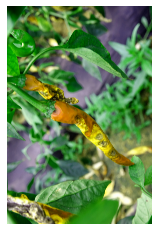

In [216]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']

#검증 데이터셋에서 랜덤으로 이미지를 선택한다
rid = np.random.randint(0, len(img_name_val)) #랜덤 아이디
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#결과(result)에서 <end> 토큰을 제거한다
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print()

print('Real Caption:', real_caption)
print('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.axis('off')
plt.imshow(temp_image)

C:\Users\DI Lee\.keras\datasets\image.jpg
Prediction Caption: 포자와 황갈색 움푹 비틀어진 띄는 것과 연한


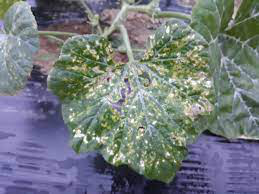

In [215]:
image_url = 'https://www.nongmin.com/upload/bbs/201708/20170801174600019/20170801174600019.jpg'
image_extension = image_url[-4:]
# print(image_extension)
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
print(image_path)
result,_, _ = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
# opening the image
Image.open(image_path)

Prediction Caption: 특별한 증상이 발견되지 않아 정상 고춧잎으로 판단됩니다


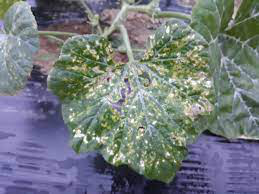

In [190]:
# image_url = 'https://www.nongmin.com/upload/bbs/201708/20170801174600019/20170801174600019.jpg'
# image_extension = image_url[-4:]
# print(image_extension)
# image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
# print(image_path)
image_path = r"C:\Users\DI Lee\.keras\datasets\image.jpg"
result, _, _ = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)